# Running model on test data...

In [1]:
import sys
sys.path.append('/Users/lucasglanville/code/lucasglanville/and_theyre_off_backend/Preprocessing')

from data_clean import get_data, dropping_no_betting_data
from sklearn.preprocessing import MinMaxScaler
from sklearn import set_config
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from keras.utils import get_custom_objects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
import warnings

warnings.filterwarnings('ignore')

In [2]:
"""1)  Getting the data and first round of preprocessing"""
###receiving all columns of data for user selected rows (by track and time)

#Get the data from the bucket
data = get_data("../../raw_data/hr_data_0409_221rem.csv")
print("data loaded")
#Fill in the missing odds
data = dropping_no_betting_data(data)
# drop stall position NAs
data = data[data['stall_position'].notna()]
#Remove horses with odds over 50 at 5m before the race
data = data[(data['f_pm_05m'] <= 50)]
#Reset index
data = data.reset_index(drop=True)

data acquired with shape (120675, 116)
data loaded
Cleaned up missing odds. New shape = (120414, 116)


In [3]:
data = data.iloc[70000:]

In [4]:
"""2)  Filling the null L16 columns with 0s"""

X_preproc = data[[
          'iv_trainer_l16r', 'iv_jockey_l16r',
          'ae_trainer_l16r' ,'ae_jockey_l16r']]
X_preproc = X_preproc.fillna(0)

In [5]:
"""3)  Scaling the numerical values and defining X"""

#Adding f_runners to X_preproc pre-scaling
X_preproc['f_runners'] = data['f_runners']
X_preproc['stall_position'] = data['stall_position']

#Loading scaler values and scaling 5 features
set_config(transform_output = "pandas")
with open('../../Models/JS_weights/scaler_updated2.pkl', 'rb') as f: # CHANGE THIS PATH to get the saved scalar
    loaded_scaler = pickle.load(f)
X = loaded_scaler.transform(X_preproc)

#Adding final 2 features that don't need scaling
X['pred_isp_prob'] = 1 / data['pred_isp']


In [6]:
X = X[['stall_position', 'iv_trainer_l16r', 'iv_jockey_l16r', 'ae_trainer_l16r', 'ae_jockey_l16r', 'pred_isp_prob', 'f_runners']]

In [7]:
"""5) Defining backtest and changing commision to 2%"""

# Define a function to create a new profit column with 2% commision
def fill_01m_profit(data):
    def fill_nan(row):
        if row['f_place'] == 0:
            return -1
        elif row['f_place'] == 1:
            return (row['f_pm_01m'] - 1) * 0.98
        else:
            return row['f_pm_01m_p_back']

# Apply the lambda function to create 01m_profit column
    data['01m_profit'] = data.apply(fill_nan, axis=1)
    return data

data = fill_01m_profit(data)

backtest = data[['f_ko', 'f_track', 'f_id', 'id','f_horse','f_pm_01m', '01m_profit', 'f_place']]

In [8]:
"""6)  Model Architecture"""

NN = Sequential()
NN.add(InputLayer(input_shape=(7, ))) # input layer
NN.add(Dense(32, activation='relu')) # hidden layer 1
NN.add(Dense(2, activation='softmax')) # output layer

In [9]:
"""7)  Loading Weights"""

NN.load_weights("../../Models/weights-JStone2609/custom_scorer0.05_7input_l16_05mfilter_01mplace") ##CHANGE PATH TO LOAD MODEL WEIGHTS

In [10]:
"""8)  Creating preds"""

y_pred = NN.predict(X)

1140/1140 [==============================] - 0s 184us/step


In [11]:
"""9) Creating backtest table"""

backtest['model_preds'] = y_pred[:, 0:1]
backtest['model_preds'] = round(backtest['model_preds'],2)
backtest = backtest.sort_values(['model_preds'], ascending = False)
backtest_live = backtest.drop(columns=['f_id', 'id', '01m_profit','f_place'])
def bet_or_nobet(x):
        if x >= 0.5:
            return "BET"
        else:
            return "NO BET"
backtest_live['bet'] = backtest_live['model_preds'].apply(bet_or_nobet)

backtest_live

,f_ko,f_track,f_horse,f_pm_01m,model_preds,bet
99801,24/07/2023 19:40,BALLINROBE,Beer With The Boys,46.0,1.0,BET
94941,24/06/2023 17:05,DOWN ROYAL,Universally,70.0,1.0,BET
104497,22/08/2023 20:15,ROSCOMMON,Blackstone Cliff,13.0,1.0,BET
72424,26/10/2022 16:35,CURRAGH,Shur Lookit,42.0,1.0,BET
72425,26/10/2022 16:35,CURRAGH,Flier,38.0,1.0,BET
...,...,...,...,...,...,...
78064,21/01/2023 14:47,LINGFIELD,Makinmedoit,10.0,0.0,NO BET
78065,21/01/2023 14:47,LINGFIELD,Tequilamockingbird,15.5,0.0,NO BET
89998,26/05/2023 19:30,CURRAGH,Rahmi,25.0,0.0,NO BET
89997,26/05/2023 19:30,CURRAGH,Earls,28.0,0.0,NO BET


In [12]:
backtest['f_ko'] = pd.to_datetime(backtest['f_ko'], format = "%d/%m/%Y %H:%M")
backtest = backtest.sort_values(['f_ko'])
df = backtest
df

,f_ko,f_track,f_id,id,f_horse,f_pm_01m,01m_profit,f_place,model_preds
70001,2022-10-07 17:35:00,YORK,1.665160e+13,1.665160e+13,King Triton,27.0,-1.0,16,0.25
70002,2022-10-07 17:35:00,YORK,1.665160e+13,1.665160e+13,Theotherside,36.0,-1.0,13,0.37
70000,2022-10-07 17:35:00,YORK,1.665160e+13,1.665160e+13,Yaaser,7.8,-1.0,12,0.02
70004,2022-10-07 17:35:00,YORK,1.665160e+13,1.665160e+13,Guess,10.5,-1.0,3,0.01
70003,2022-10-07 17:35:00,YORK,1.665160e+13,1.665160e+13,Royal Musketeer,50.0,-1.0,15,0.86
...,...,...,...,...,...,...,...,...,...
106443,2023-09-03 17:30:00,TIPPERARY,1.693760e+13,1.693760e+13,Humtaza,13.0,-1.0,7,0.66
106444,2023-09-03 17:30:00,TIPPERARY,1.693760e+13,1.693760e+13,Rock On Seamie,28.0,-1.0,12,0.27
106449,2023-09-03 17:30:00,TIPPERARY,1.693760e+13,1.693760e+13,Butterfly Garden,25.0,-1.0,9,0.02
106459,2023-09-03 17:30:00,TIPPERARY,1.693760e+13,1.693760e+13,Kings Prince,12.0,-1.0,2,0.01


In [13]:
df = df[df['f_pm_01m'] < 50]
df

,f_ko,f_track,f_id,id,f_horse,f_pm_01m,01m_profit,f_place,model_preds
70001,2022-10-07 17:35:00,YORK,1.665160e+13,1.665160e+13,King Triton,27.0,-1.0,16,0.25
70002,2022-10-07 17:35:00,YORK,1.665160e+13,1.665160e+13,Theotherside,36.0,-1.0,13,0.37
70000,2022-10-07 17:35:00,YORK,1.665160e+13,1.665160e+13,Yaaser,7.8,-1.0,12,0.02
70004,2022-10-07 17:35:00,YORK,1.665160e+13,1.665160e+13,Guess,10.5,-1.0,3,0.01
70008,2022-10-07 17:45:00,NEWCASTLE,1.665160e+13,1.665160e+13,Gliding Bay,5.0,-1.0,3,0.00
...,...,...,...,...,...,...,...,...,...
106443,2023-09-03 17:30:00,TIPPERARY,1.693760e+13,1.693760e+13,Humtaza,13.0,-1.0,7,0.66
106444,2023-09-03 17:30:00,TIPPERARY,1.693760e+13,1.693760e+13,Rock On Seamie,28.0,-1.0,12,0.27
106449,2023-09-03 17:30:00,TIPPERARY,1.693760e+13,1.693760e+13,Butterfly Garden,25.0,-1.0,9,0.02
106459,2023-09-03 17:30:00,TIPPERARY,1.693760e+13,1.693760e+13,Kings Prince,12.0,-1.0,2,0.01


# Simulated Results & Analysis

We split our data chronologically to ensure no look-ahead bias. Hence, our test set for these simulated results spans the last 12 months - from October 2022 to September 2023. It contains 4,150 races.

## 1. Comparing our model to baseline strategies

Here are our simulated profits of betting £1 on each horse that our model indicates. To compare, we also show the results of betting £1 every race on the horse with the best odds, betting £1 on every horse, and one of the best strategies there is, not betting at all.

Unsurprisingly, betting on every horse is a sure-fire way to lose all your money. Betting on the horse with the best odds appears to be a surprisingly effective strategy, almost breaking even. Our neural network model is profitable over this test set, and over a reasonably large sample size too - it places 999 total bets over the 4150 races.

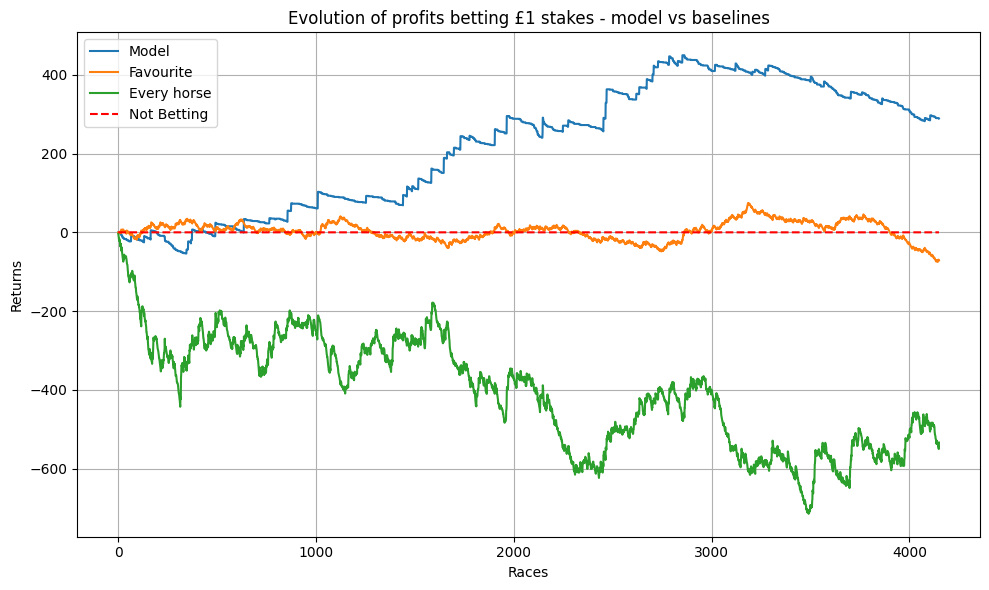

In [36]:
def calculate_cumulative_profit_model_threshold(df, threshold):
    bets = df[df['model_preds'] >= threshold]  # Filter based on model prediction threshold
    race_profits = bets.groupby(['f_ko', 'f_id', 'f_track'])['01m_profit'].sum().reset_index() # Group by unique race and sum the profit
    all_races = df[['f_ko', 'f_id', 'f_track']].drop_duplicates() # Create a DataFrame with every unique race from the original test data
    merged = pd.merge(all_races, race_profits, on=['f_ko', 'f_id', 'f_track'], how='left').fillna(0) # Merge with race_profits; fill NAs with 0 (no profit/loss if we didn't bet)
    merged['cumulative_profit'] = merged['01m_profit'].cumsum()  # Sum the profit
    return merged['cumulative_profit']
def calculate_cumulative_profit_favourite(df):
    # Sort by 'f_ko', 'f_id', 'f_track', and 'f_pm_01m' to get the favourite for each race
    favorites = df.sort_values(by=['f_ko', 'f_id', 'f_track', 'f_pm_01m']).groupby(['f_ko', 'f_id', 'f_track']).first().reset_index()
    return favorites['01m_profit'].cumsum()  # Sum the profit
def calculate_cumulative_profit_every_horse(df):
    race_profits = df.groupby(['f_ko', 'f_id', 'f_track'])['01m_profit'].sum().reset_index() # Group by unique race and sum the profit
    all_races = df[['f_ko', 'f_id', 'f_track']].drop_duplicates() # Create a DataFrame with every unique race
    merged = pd.merge(all_races, race_profits, on=['f_ko', 'f_id', 'f_track'], how='left').fillna(0) # Merge with race_profits; fill NAs with 0 (no profit/loss if we didn't bet)
    merged['cumulative_profit'] = merged['01m_profit'].cumsum() # Calculate cumulative profit
    return merged['cumulative_profit']

every_horse_profit = calculate_cumulative_profit_every_horse(df) # Calculate cumulative profits for betting on every horse
favorite_profit = calculate_cumulative_profit_favourite(df) # Calculate cumulative profits for betting on favorites
model_profit = calculate_cumulative_profit_model_threshold(df, threshold = 0.9) # Calculate cumulative profits for betting with model
plt.figure(figsize=(10, 6))
plt.plot(range(len(model_profit)), model_profit, label=f"Model") # Plot for model
plt.plot(range(len(favorite_profit)), favorite_profit, label='Favourite') # Plot for favorite
plt.plot(range(len(every_horse_profit)), every_horse_profit, label='Every horse') # Plot for every horse
plt.plot(range(len(favorite_profit)), [0] * (len(favorite_profit)), color='r', linestyle='--', label='Not Betting') # Plot for not betting
plt.title("Evolution of profits betting £1 stakes - model vs baselines")
plt.xlabel("Races")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. Monthly metrics

Here are monthly metrics from our simulated results. There are more races - and thus more bets placed - in the summer months. The model makes a profit in 8 out of the 12 months, but it's difficult to discern any seasonal patterns in our returns without more than a single year of test data.

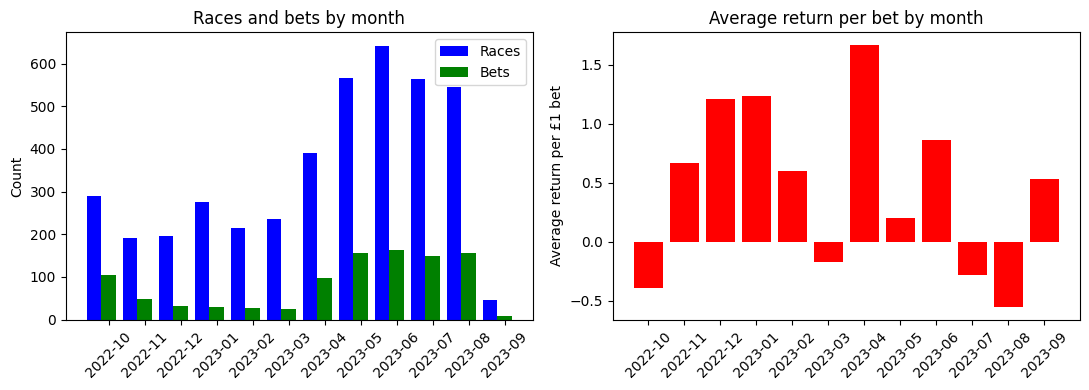

In [15]:
df['year_month'] = df['f_ko'].dt.to_period('M')  # Extracting month and year from f_ko - gives a column with YYYY-MM format
races_per_month = df.drop_duplicates(subset=['f_ko', 'f_id', 'f_track'])['year_month'].value_counts().sort_index() # Calculating number of races per month
bets = df[df['model_preds'] >= 0.9] # Filtering dataframe for bets placed
bets_per_month = bets.groupby('year_month').size() # Calculating number of bets placed by month
profit_per_month = bets.groupby('year_month')['01m_profit'].sum() # Profit by month
returns_per_bet = profit_per_month / bets_per_month # Returns per bet by month
fig, axes = plt.subplots(1, 2, figsize=(11, 4)) # Subplots
bar_width = 0.4
r1 = range(len(races_per_month))
r2 = [x + bar_width for x in r1] # We want races and bets per month on the same axes
axes[0].bar(r1, races_per_month.values, width=bar_width, color='blue', label='Races')
axes[0].bar(r2, bets_per_month.values, width=bar_width, color='green', label='Bets')
axes[0].set_title('Races and bets by month')
axes[0].set_ylabel('Count')
axes[0].set_xticks([r + bar_width for r in range(len(races_per_month))])
axes[0].set_xticklabels(races_per_month.index.astype(str))
axes[0].legend()
axes[1].bar(returns_per_bet.index.astype(str), returns_per_bet.values, color='red') # Returns per bet by month
axes[1].set_title('Average return per bet by month')
axes[1].set_ylabel('Average return per £1 bet')
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45) # Rotate x-tick labels
plt.tight_layout()
plt.show()

## 3. Exploring different model confidence thresholds

A decision we had to make was choosing the model confidence 'threshold' for placing a bet. Should we place a bet every time our model outputs a confidence value above 50%? Or allow ourselves a buffer by raising the threshold for placing a bet?

The first graph below shows the simulated returns of betting £1 on horses using different confidence thresholds for bet-placing. On our test data, using a 90% confidence threshold generated almost the same total profit as using a 50% confidence threshold in less than half as many bets, and actually generated higher total profit than using a 70% threshold. As the third graph shows, bets placed solely on horses in the 50%-90% confidence band barely made positive returns.

For this reason, a 90% confidence threshold for bet-placing was chosen for our final model.

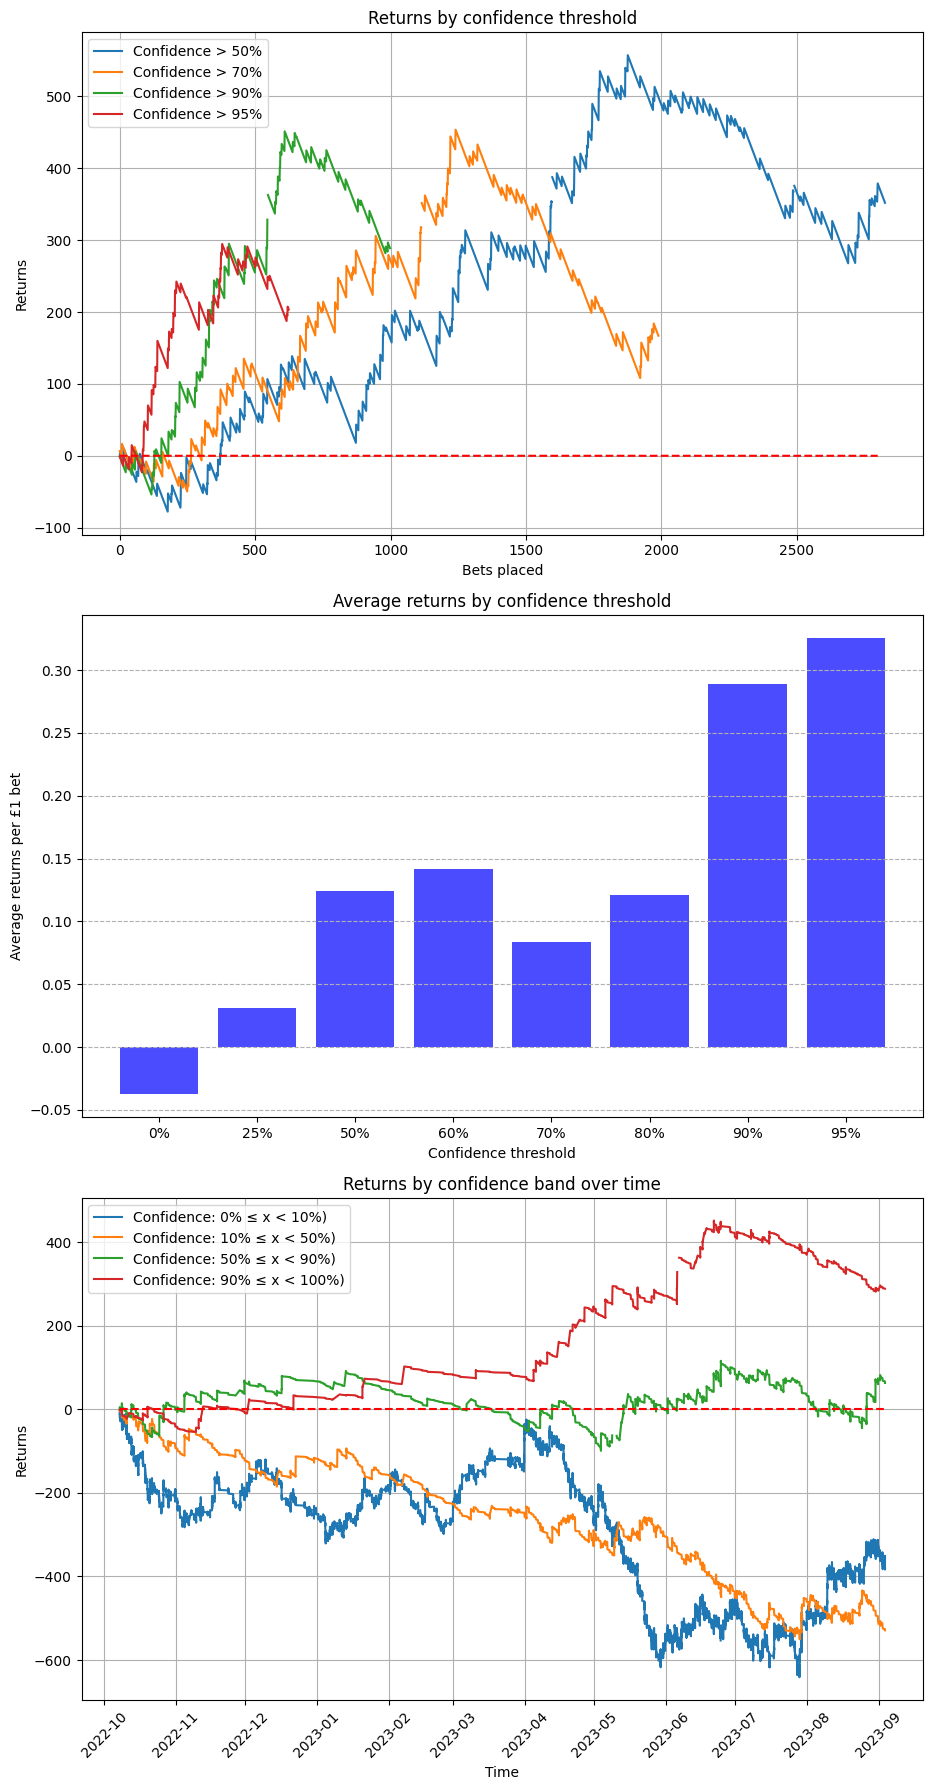

In [35]:
def calculate_cumulative_profit_over_bets(df, threshold):
    df = df[df['model_preds'] >= threshold] # Filter based on model prediction threshold
    return df['01m_profit'].cumsum() # Sum the profits
def calculate_average_return_per_bet(df, threshold):
    bets_made = df[df['model_preds'] >= threshold]
    return bets_made['01m_profit'].sum() / len(bets_made) # Total returns / total number of bets
def calculate_cumulative_profit_over_bands(df, lower_threshold, upper_threshold):
    df = df[(df['model_preds'] >= lower_threshold) & (df['model_preds'] < upper_threshold)] # Filter based on model prediction threshold band
    return df['01m_profit'].cumsum()  # Sum the profits
fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], height_ratios=[1,1,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[2])
# ax2 = plt.subplot(gs[4])
ax3 = plt.subplot(gs[4])
# First plot: Evolution of profits betting £1 stakes - comparing model confidence thresholds
thresholds = [0.5, 0.70, 0.9, 0.95]
for threshold in thresholds:
    cumulative_profit = calculate_cumulative_profit_over_bets(df, threshold)
    ax0.plot(range(len(cumulative_profit)), cumulative_profit, label=f"Confidence > {round((threshold*100))}%")
ax0.plot(range(2800), [0] * 2800, color='r', linestyle='--')
ax0.set_title("Returns by confidence threshold")
ax0.set_xlabel("Bets placed")
ax0.set_ylabel("Returns")
ax0.grid(True)
ax0.legend(loc='upper left')
# Second plot: Average Returns per bet by model confidence threshold
thresholds = [0.001, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
average_returns = [calculate_average_return_per_bet(df, threshold) for threshold in thresholds] # Calculate average returns for each threshold
ax1.bar(range(len(thresholds)), average_returns, color='blue', alpha=0.7)
ax1.set_title("Average returns by confidence threshold")
ax1.set_xlabel("Confidence threshold")
ax1.set_ylabel("Average returns per £1 bet")
ax1.set_xticks(range(len(thresholds)))
ax1.set_xticklabels([f"{round(t*100)}%" for t in thresholds])
ax1.grid(axis='y', linestyle='--')
# # Third plot: Evolution of profits betting £1 stakes - comparing model confidence bands
# threshold_bands = [(0.5, 0.9), (0.9, 1.00001)]
# for lower, upper in threshold_bands:
#     cumulative_profit = calculate_cumulative_profit_over_bands(df, lower, upper)
#     ax2.plot(range(len(cumulative_profit)), cumulative_profit, label=f"Confidence: {round((lower*100))}% ≤ x < {round((upper*100))}%)")
# ax2.plot(range(1875), [0] * 1875, color='r', linestyle='--')
# ax2.set_title("Returns by confidence band")
# ax2.set_xlabel("Bets placed")
# ax2.set_ylabel("Returns")
# ax2.grid(True)
# ax2.legend()

# Fourth plot: Returns by confidence band with time as the X axis
threshold_bands = [(0,0.1), (0.1, 0.5), (0.5, 0.9), (0.9, 1.00001)]
for lower, upper in threshold_bands:
    sub_df = df[(df['model_preds'] >= lower) & (df['model_preds'] < upper)]
    cumulative_profit_time = sub_df['01m_profit'].cumsum()
    ax3.plot(sub_df['f_ko'], cumulative_profit_time, label=f"Confidence: {round((lower*100))}% ≤ x < {round((upper*100))}%)")
ax3.plot(sub_df['f_ko'], [0] * cumulative_profit_time, color='r', linestyle='--')
ax3.set_title("Returns by confidence band over time")
ax3.set_xlabel("Time")
ax3.set_ylabel("Returns")
# ax3.set_xticks(ax3.get_xticks())
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## 4. Exploring different odds bands

Don't have much to say on this. Might leave it out

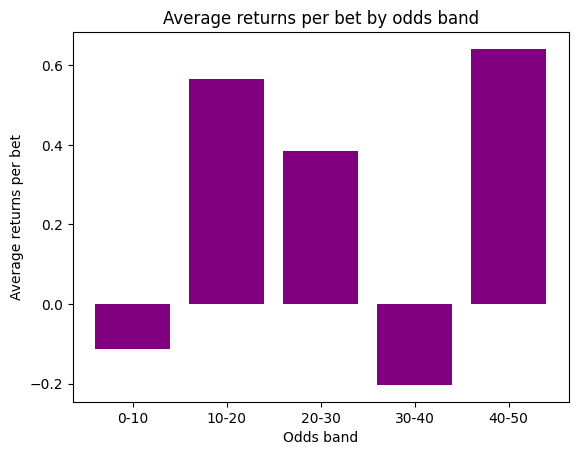

In [17]:
import matplotlib.pyplot as plt

def profit_by_odds_band(df, lower_bound, upper_bound):
    df_band = df[(df['f_pm_01m'] >= lower_bound) & (df['f_pm_01m'] < upper_bound)]
    return df_band['01m_profit'].sum()

def bets_by_odds_band(df, lower_bound, upper_bound):
    df_band = df[(df['f_pm_01m'] >= lower_bound) & (df['f_pm_01m'] < upper_bound)]
    return len(df_band)

bands = [(0,10), (10,20), (20, 30), (30, 40), (40,50)]
profits = [profit_by_odds_band(df[df['model_preds'] >= 0.9], lower, upper) for lower, upper in bands]
bets = [bets_by_odds_band(df[df['model_preds'] >= 0.9], lower, upper) for lower, upper in bands]

# Calculate profit per bet for each band
profit_per_bet = [p/b if b != 0 else 0 for p, b in zip(profits, bets)]

plt.bar([f"{l}-{u}" for l, u in bands], profit_per_bet, color="purple")
plt.title("Average returns per bet by odds band")
plt.ylabel("Average returns per bet")
plt.xlabel("Odds band")
plt.show()

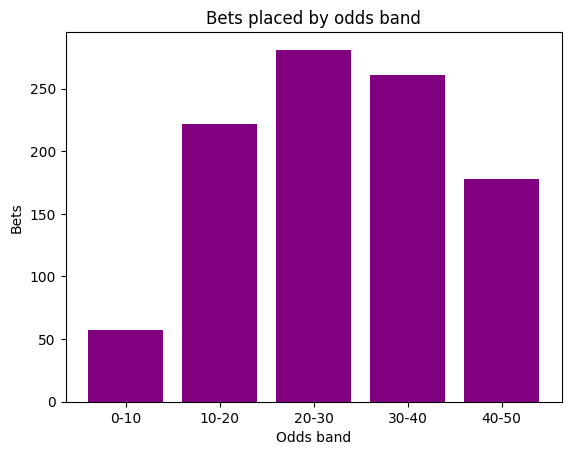

In [38]:
plt.bar([f"{l}-{u}" for l, u in bands], bets, color="purple")
plt.title("Bets placed by odds band")
plt.ylabel("Bets")
plt.xlabel("Odds band")
plt.show()